In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
np.random.seed(123) # make this notebook reproduceable. 

In [3]:
import lmfit

Following Khalil et al. (http://arxiv.org/abs/1108.3117), we can model the forward transmission of a microwave resonator with total quality factor $Q$, coupling quality factor $Q_e$, and resonant frequency $f_0$ using:

$$ S_{21}(f) = 1-\frac{Q\,Q_e^{-1}}{1+2jQ(f-f_0)/f_0} $$.

$S_{21}$ is thus a complex function of a real frequency.

By allowing $Q_e$ to be complex, this model can take into account mismatches in the input and output transmission impedances.

Since `scipy.optimize` and `lmfit` require real parameters, we represent $Q_e$ as `Q_e_real + 1j*Q_e_imag`.

In [4]:
def linear_resonator(f, f_0, Q, Q_e_real, Q_e_imag):
    Q_e = Q_e_real + 1j*Q_e_imag
    return (1 - (Q * Q_e**-1 /
                     (1 + 2j * Q * (f - f_0) / f_0)))

The standard practice of defining an `lmfit` model is as follows:

In [5]:
dict().pop('verbose',None)

In [6]:
class ResonatorModel(lmfit.model.Model):
    __doc__ = "resonator model" + lmfit.models.COMMON_DOC
    def __init__(self, *args, **kwargs):
        # pass in the defining equation so the user doesn't have to later.
        super(ResonatorModel, self).__init__(linear_resonator, *args, **kwargs)
        
        self.set_param_hint('Q', min = 0)  # Enforce Q is positive
    
    def guess(self, data, f=None, **kwargs):
        verbose = kwargs.pop('verbose',None)
        if f is None:
            return
        argmin_s21 = np.abs(data).argmin()
        fmin = f.min()
        fmax = f.max()
        f_0_guess = f[argmin_s21] # guess that the resonance is the lowest point
        Q_min = 0.1 * (f_0_guess/(fmax-fmin)) # assume the user isn't trying to fit just a small part of a resonance curve.
        delta_f = np.diff(f) #assume f is sorted
        min_delta_f = delta_f[delta_f>0].min()
        Q_max = f_0_guess/min_delta_f # assume data actually samples the resonance reasonably
        Q_guess = np.sqrt(Q_min*Q_max) # geometric mean, why not?
        Q_e_real_guess = Q_guess/(1-np.abs(data[argmin_s21]))
        if verbose:
            print "fmin=",fmin,"fmax=",fmax,"f_0_guess=",f_0_guess
            print "Qmin=",Q_min,"Q_max=",Q_max,"Q_guess=",Q_guess,"Q_e_real_guess=",Q_e_real_guess
        params = self.make_params(Q=Q_guess, Q_e_real=Q_e_real_guess, Q_e_imag=0, f_0=f_0_guess)
        params['%sQ' % self.prefix].set(min=Q_min, max=Q_max)
        params['%sf_0' % self.prefix].set(min=fmin, max=fmax)
        return lmfit.models.update_param_vals(params,self.prefix,**kwargs)

Now let's use the model to generate some fake data

In [7]:
resonator = ResonatorModel()

In [8]:
true_params = resonator.make_params(f_0=100,Q=10000,Q_e_real=9000,Q_e_imag=-9000)

In [9]:
f = np.linspace(99.95,100.05,100)
true_s21 = resonator.eval(params=true_params,f=f)
noise_scale = 0.02
measured_s21 = true_s21 + noise_scale*(np.random.randn(100) + 1j*np.random.randn(100))

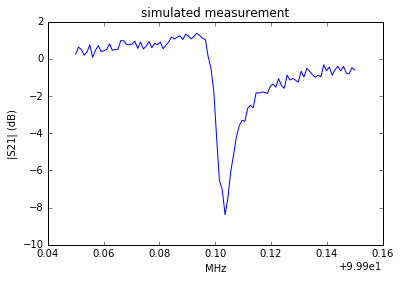

In [10]:
plot(f,20*np.log10(np.abs(measured_s21)))
ylabel('|S21| (dB)')
xlabel('MHz')
title('simulated measurement')

Try out the guess method we added:

In [11]:
guess = resonator.guess(measured_s21,f=f,verbose=True)

fmin= 99.95 fmax= 100.05 f_0_guess= 100.003535354
Qmin= 100.003535354 Q_max= 99003.5000006 Q_guess= 3146.53778182 Q_e_real_guess= 5082.24742654


And now fit the data using the guess as a starting point:

In [12]:
result = resonator.fit(measured_s21,params=guess,f=f,verbose=True)

In [13]:
print result.fit_report()

[[Model]]
    Model(linear_resonator)
[[Fit Statistics]]
    # function evals   = 38
    # data points      = 200
    # variables        = 4
    chi-square         = 0.085
    reduced chi-square = 0.000
[[Variables]]
    Q:          10059.4925 +/- 142.2947 (1.41%) (init= 3146.538)
    f_0:        100.000095 +/- 7.04e-05 (0.00%) (init= 100.0035)
    Q_e_real:   9180.61940 +/- 133.7768 (1.46%) (init= 5082.247)
    Q_e_imag:  -9137.03297 +/- 133.7702 (1.46%) (init= 0)
[[Correlations]] (unreported correlations are <  0.100)
    C(Q, Q_e_real)               =  0.518 
    C(f_0, Q_e_imag)             =  0.517 
    C(f_0, Q_e_real)             =  0.515 
    C(Q, Q_e_imag)               = -0.515 



Now we'll make some plots of the data and fit. Define a convenience function for plotting complex quantities

In [14]:
def plot_ri(data,*args,**kwargs):
    plot(data.real,data.imag,*args,**kwargs)

In [15]:
fit_s21 = resonator.eval(params=result.params,f=f)
guess_s21 = resonator.eval(params=guess,f=f)

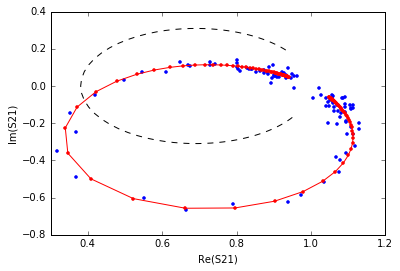

In [16]:
plot_ri(measured_s21,'.')
plot_ri(fit_s21,'r.-')
plot_ri(guess_s21,'k--')
xlabel('Re(S21)')
ylabel('Im(S21)')

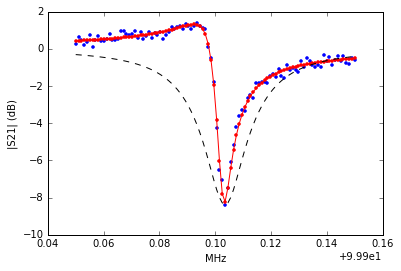

In [17]:
plot(f,20*np.log10(np.abs(measured_s21)),'.')
plot(f,20*np.log10(np.abs(fit_s21)),'r.-')
plot(f,20*np.log10(np.abs(guess_s21)),'k--')
ylabel('|S21| (dB)')
xlabel('MHz')